In this notebook we will implement a simple deep learning model in keras. We use [a dataset of 20 bird species](https://www.kaggle.com/datasets/umairshahpirzada/birds-20-species-image-classification/data).

In [ ]:
import keras
print(keras.__version__)
print(keras.backend.backend())

3.8.0
tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/projects/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset') #extract to the /content/dataset directory

Mounted at /content/drive


In [ ]:
import os
from keras.utils import image_dataset_from_directory

base_dir = '/content/dataset'
test_dir = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

val_dataset = image_dataset_from_directory(
    valid_dir,
    image_size=(224, 224),
    batch_size=100,
    label_mode="categorical"
)

Found 3208 files belonging to 20 classes.
Found 100 files belonging to 20 classes.


To prevent overfitting, we will augment the training data. Images in the dataset are already cropped such that the bird occupies at least 50% of the image, so some augmentations such as RandomZoom are not useful.

In [ ]:
from keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="nearest"),
])

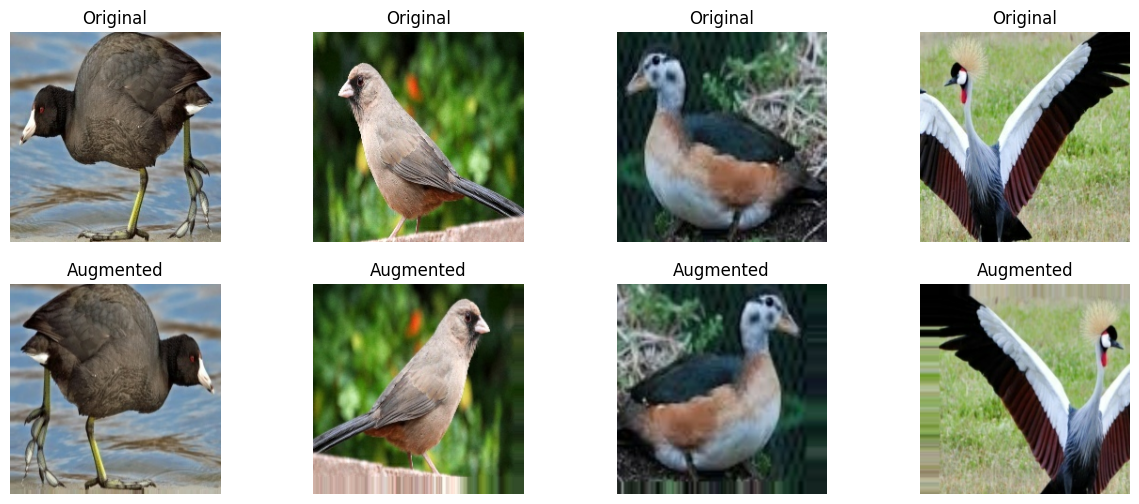

In [ ]:
import matplotlib.pyplot as plt

# Take one batch of images
sample_batch = next(iter(train_dataset))  # Get one batch
sample_images = sample_batch[0][:4]  # Take 4 images for visualization

# Apply data augmentation
augmented_images = data_augmentation(sample_images, training=True)

# Plot original and augmented images
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

for i in range(4):
    axes[0, i].imshow(sample_images[i].numpy().astype("uint8"))
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    axes[1, i].imshow(augmented_images[i].numpy().astype("uint8"))
    axes[1, i].axis("off")
    axes[1, i].set_title("Augmented")

plt.show()


We implement a simple convolutional neural network. It includes dropout layers to prevent overfitting.

In [ ]:
from tensorflow.keras.regularizers import l2
from keras import optimizers

dropout_rate = 0.8

model = keras.Sequential([
    keras.Input(shape=(224, 224, 3)),

    data_augmentation,

    keras.layers.Rescaling(1./255),  # Normalize pixel values

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # layers.Conv2D(256, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(256, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),

    # layers.Conv2D(512, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(512, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    # layers.Dropout(dropout_rate),
    # layers.Dense(2048, activation='relu'),
    # layers.Dropout(dropout_rate),
    # layers.Dense(1024, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(512, activation='relu'),
    layers.Dense(20, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,688,788 (36.96 MB)

 Trainable params: 9,688,788 (36.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import schedules

n = len(train_dataset)
boundaries1 = [40,60,80]
boundaries = [i * n for i in boundaries1]
values = [1e-3, 8e-4, 4e-4, 1e-4]
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=100,  # Train for full duration
    validation_data=val_dataset,
    validation_steps=len(val_dataset)
)

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - acc: 0.0613 - loss: 3.3623 - val_acc: 0.2000 - val_loss: 3.1080
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - acc: 0.2166 - loss: 2.5829 - val_acc: 0.4000 - val_loss: 2.0085
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - acc: 0.3673 - loss: 2.0060 - val_acc: 0.4300 - val_loss: 1.6297
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - acc: 0.4751 - loss: 1.7233 - val_acc: 0.5100 - val_loss: 1.7223
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - acc: 0.5246 - loss: 1.6119 - val_acc: 0.3300 - val_loss: 3.4095
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - acc: 0.5312 - loss: 1.5004 - val_acc: 0.6900 - val_loss: 1.0500
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - acc: 0.6070 - loss: 1.2777 - val_acc: 0.7200 - val_loss: 0.7508
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - acc: 0.6276 - loss: 1.2018 - val_acc: 0.7100 - val_loss: 0.8453
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━

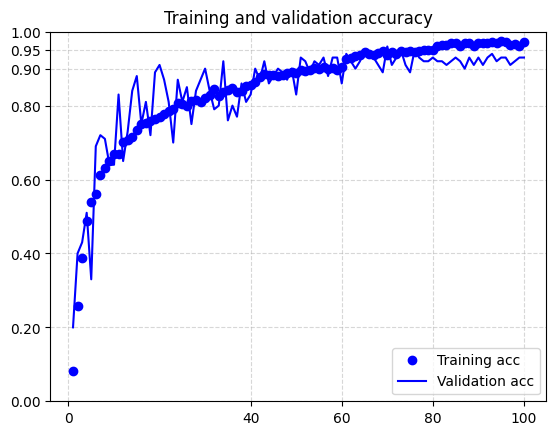

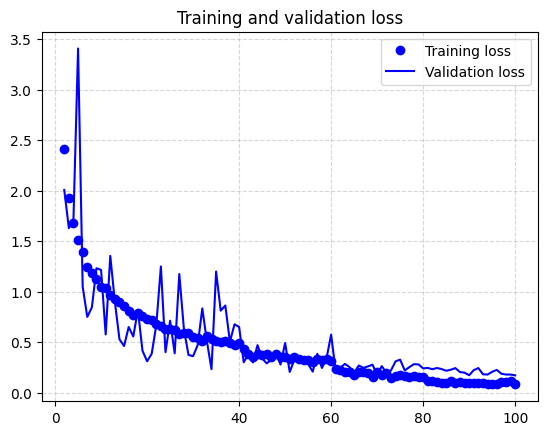

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.ylim(0, 1)  # Ensure it covers the full range up to 1
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1])  # Include 0.8, 0.9, and 1 explicitly
plt.xticks([0] + boundaries1 + [100])
plt.figure()
plt.plot(epochs[1:], loss[1:], 'bo', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.xticks([0] + boundaries1 + [100])
plt.show()

In [ ]:
from PIL import Image
import numpy as np
import os

# Define image directory
image_directory = os.path.join(base_dir, 'images to predict')

# Load class names from train_dataset
labels = train_dataset.class_names  # Get class labels

# Load images
images = []
for filename in os.listdir(image_directory):
    path = os.path.join(image_directory, filename)
    images.append(np.array(Image.open(path)))

# Convert to NumPy array and normalize
images = np.array(images)

# Make predictions
predictions = model.predict(images)

# Print results
for i, pred in enumerate(predictions):
    predicted_class = np.argmax(pred)  # Get index of highest probability class
    class_probability = pred[predicted_class]
    print(f'Predicted class for {i+1}.jpg : {labels[predicted_class]}')
    print('Class probability:', class_probability)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Predicted class for 1.jpg : AFRICAN CROWNED CRANE
Class probability: 0.9812883
Predicted class for 2.jpg : AFRICAN CROWNED CRANE
Class probability: 1.0
Predicted class for 3.jpg : AFRICAN CROWNED CRANE
Class probability: 1.0
Predicted class for 4.jpg : ABBOTTS BOOBY
Class probability: 0.95201385
Predicted class for 5.jpg : AFRICAN CROWNED CRANE
Class probability: 0.99999213
Predicted class for 6.jpg : AFRICAN CROWNED CRANE
Class probability: 0.99998915


In [ ]:
# Load the test dataset
test_dataset = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),  # Ensure it matches model input size
    batch_size=100,  # Use a reasonable batch size
    label_mode="categorical"  # Match the model's output
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)

# Print final test accuracy
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

Found 100 files belonging to 20 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - acc: 0.9500 - loss: 0.1912
Final Test Accuracy: 0.9500
Final Test Loss: 0.1912
